# Rabi experiment

In this tutorial we will combine the techniques explained in the other tutorials and show how to perform a Rabi experiment. For this tutorial we will need one QCM to generate the Rabi pulses and one QRM to perform the readout, although the QCM could be replaced by another QRM if needed.

Ports $\text{O}^{[1-2]}$ of the QCM are used for the driving pulse, while $\text{O}^{[1-2]}$ of the QRM are used for the readout pulse. Finally, ports $\text{I}^{[1-2]}$ are used for the acquisition of the readout tone. In this tutorial it is assumed $\text{O}^{1}$ of the QRM is connected to $\text{I}^{1}$ of the QRM for time of flight calibration.
Furthermore we assume that $\text{O}^{1}$ of the QCM and $\text{O}^{2}$ of the QRM are connected to an external oscilloscope to view the Rabi experiment pattern. The scope can be triggered of marker 1 of the QCM.

As demonstrated in the synchronization tutorial, the SYNQ technology synchronizes the programs in the two modules. If you are using Pulsar modules,
to ensure synchronization between the modules, connect the $\text{REF}^{out}$ of the Pulsar QCM to the 
$\text{REF}^{in}$ of the Pulsar QRM using a coaxial cable, and connect their SYNQ ports using the SYNQ cable.

If you are using a Cluster, then no extra connection needs to be made as the modules are internally connected with SYNQ capability.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

## Setup


First, we are going to import the required packages and connect to the instrument.

In [1]:
# Import ipython widgets
import json
import math

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive
from qcodes import Instrument
from qblox_instruments import Cluster, PlugAndPlay, Pulsar

### Scan For Devices

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/tools.html#plug-play) for more info).

In [2]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()

names = {dev_id: dev_info["description"]["name"] for dev_id, dev_info in device_list.items()}
ip_addresses = {dev_id: dev_info["identity"]["ip"] for dev_id, dev_info in device_list.items()}

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[
        (names[dev_id] + " @" + ip_addresses[dev_id], dev_id) for dev_id in device_list.keys()
    ],
    description="Select Device",
)
display(connect)

Dropdown(description='Select Device', options=(('Marketing-Cluster @192.168.1.170', '00015_2247_002'),), value…

### Connect to Cluster

We now make a connection with the Cluster selected in the dropdown widget. We also define a function to find the modules we're interested in. We select the readout and control module we want to use.

In [3]:
# Connect to device
dev_id = connect.value
# Close the chosen QCodes instrument as to prevent name clash.
try:
    Instrument.find_instrument(names[dev_id]).close()
except KeyError:
    pass

cluster = Cluster(name=names[dev_id], identifier=ip_addresses[dev_id])

print(f"{connect.label} connected")
print(cluster.get_system_state())

C:\ProgramData\anaconda3\envs\quantify-env\lib\site-packages\qcodes\instrument\instrument_base.py:543: UserWarning: Changed Marketing-Cluster to Marketing_Cluster for instrument identifier
  warnings.warn(f"Changed {name} to {new_name} for instrument identifier")


Marketing-Cluster @192.168.1.170 connected
Status: OKAY, Flags: NONE, Slot flags: NONE


In [4]:
def select_module_widget(
    device, select_all=False, select_qrm_type: bool = True, select_rf_type: bool = True
):
    """Create a widget to select modules of a certain type

    default is to show only QRM baseband

    Args:
        devices : Cluster we are currently using
        select_all (bool): ignore filters and show all modules
        select_qrm_type (bool): filter QRM/QCM
        select_rf_type (bool): filter RF/baseband
    """
    options = [[None, None]]

    for module in device.modules:
        if module.present():
            if select_all or (
                module.is_qrm_type == select_qrm_type and module.is_rf_type == select_rf_type
            ):
                options.append(
                    [
                        f"{device.name} "
                        f"{module.short_name} "
                        f"({module.module_type}{'_RF' if module.is_rf_type else ''})",
                        module,
                    ]
                )
    widget = widgets.Dropdown(options=options)
    display(widget)

    return widget

In [5]:
print("Select the readout module from the available modules:")
select_readout_module = select_module_widget(cluster, select_qrm_type=True, select_rf_type=True)

Select the readout module from the available modules:


Dropdown(options=([None, None], ['Marketing_Cluster module8 (QRM_RF)', <QcmQrm: Marketing_Cluster_module8 of C…

In [6]:
readout_module = select_readout_module.value
print(f"{readout_module} connected")

<QcmQrm: Marketing_Cluster_module8 of Cluster: Marketing_Cluster> connected


In [7]:
print("Select the control module from the available modules:")
select_control_module = select_module_widget(cluster, select_qrm_type=False, select_rf_type=True)

Select the control module from the available modules:


Dropdown(options=([None, None], ['Marketing_Cluster module4 (QCM_RF)', <QcmQrm: Marketing_Cluster_module4 of C…

In [8]:
control_module = select_control_module.value
print(f"{control_module} connected")

<QcmQrm: Marketing_Cluster_module4 of Cluster: Marketing_Cluster> connected


## Sequencer Setup <a id='seq_setup'></a>


Set `sync_en` to synchronize across modules.

In [9]:
# Set sync_en
readout_module.sequencer0.sync_en(True)
control_module.sequencer0.sync_en(True)

Configure the `NCO` of both the QRM and QCM to 100 MHz and enable the up- and down-conversion in the sequencers

In [10]:
readout_module.sequencer0.nco_freq(100e6)
readout_module.sequencer0.mod_en_awg(True)
readout_module.sequencer0.demod_en_acq(True)

control_module.sequencer0.nco_freq(100e6)
control_module.sequencer0.mod_en_awg(True)

Configure the outputs of the QRM and QCM such that sequencer0 is the only enabled sequencer and maps to $\text{O}^{[1-2]}$

In [11]:
# Map sequencer of the QCM to specific outputs (but first disable all sequencer connections)
control_module.disconnect_outputs()

control_module.sequencer0.connect_sequencer("out0")

# Map sequencer of the QRM to specific outputs (but first disable all sequencer connections)
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

readout_module.sequencer0.connect_sequencer("io0")

## Define waveforms

To readout the systems we define constant pulses `one` and `zero` which will be up converted by the `NCO` to create the appropriate tones for an IQ mixer.
Similarly for driving the qubit, we define a Gaussian pulse, together with a zero pulse of equal length to serve as inputs for an IQ mixer. In this tutorial we do not assume mixers to be connected to the inputs and outputs of the QCM/QRM.

In [12]:
t = np.arange(-80, 81, 1)
sigma = 20
wfs = {
    "zero": {"index": 0, "data": [0.0] * 1024},
    "one": {"index": 1, "data": [1.0] * 1024},
    "gauss": {"index": 2, "data": list(np.exp(-(0.5 * t**2 / sigma**2)))},
    "empty": {"index": 3, "data": list(0.0 * t)},
}

Hence we obtain the following waveforms for readout:

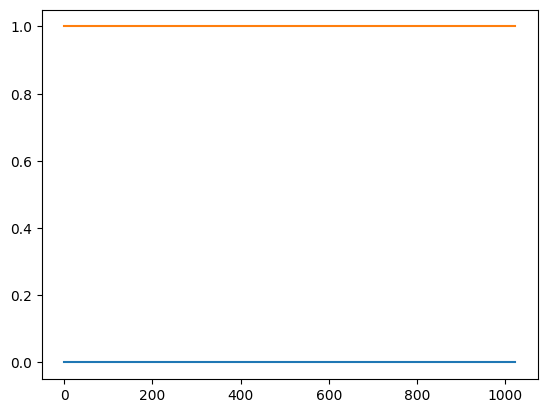

In [13]:
plt.plot(wfs["zero"]["data"])
plt.plot(wfs["one"]["data"])

And for drive:

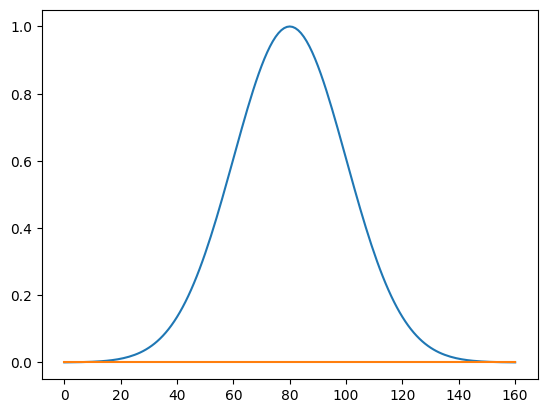

In [14]:
plt.plot(wfs["gauss"]["data"])
plt.plot(wfs["empty"]["data"])

Finally, we define two acquisitions. A single readout to perform the calibration measurements. Secondly we create a `rabi` readout sequence that contains 50 different bins for saving the results, one for each of the different amplitudes used for the drive tone.

In [15]:
num_bins = 50  # Number of amplitudes to be measured
acquisitions = {
    "single": {"num_bins": 1, "index": 0},
    "rabi": {"num_bins": num_bins, "index": 1},
}

## Calibration experiments

### TOF calibration

As a first step, we calibrate the time of flight (tof) for the QRM module. In order to do so, we play a readout pulse and analyze the obtained signal on the oscilloscope to find the travel time of the pulse through the system.

In [16]:
qrm_prog = f"""
play    1, 0, 4     # start readout pulse
acquire 0, 0, 16384 # start the 'single' acquisition sequence and wait for the length of the scope acquisition window
stop
"""

Upload the program, together with the waveforms and acquisitions to the QRM

In [17]:
sequence = {
    "waveforms": wfs,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qrm_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Perform the calibration experiment

In [18]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Wait for the sequencer and acquisition to finish with a timeout period of one minute.
readout_module.get_acquisition_state(0, 1)
readout_module.store_scope_acquisition(0, "single")
# Print status of sequencer.
print(readout_module.get_sequencer_state(0))

Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Analyze the resulting signal on the scope to find the tof

In [19]:
p0 = np.array(readout_module.get_acquisitions(0)["single"]["acquisition"]["scope"]["path0"]["data"])
p1 = np.array(readout_module.get_acquisitions(0)["single"]["acquisition"]["scope"]["path1"]["data"])
# Determine when the signal crosses half-max for the first time (in ns)
t_halfmax = np.where(np.abs(p0) > np.max(p0) / 2)[0][0]

# The time it takes for a sine wave to reach its half-max value is (in ns)
correction = 1 / readout_module.sequencer0.nco_freq() * 1e9 / 12

tof_measured = t_halfmax - correction

Plot the signal on the scope, around the rising and falling edge of the acquisition signal, as determined by the tof analysis above:

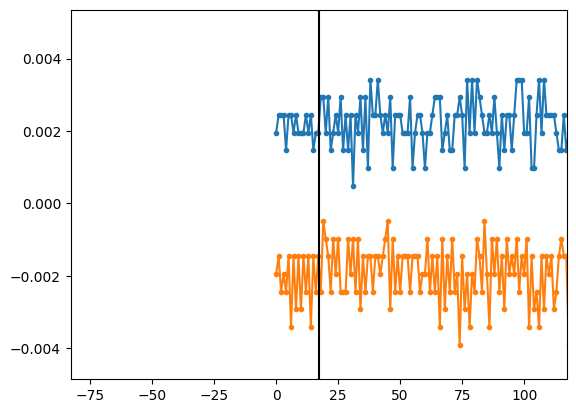

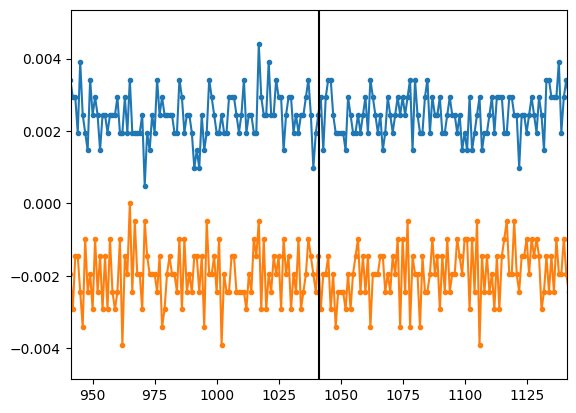

In [20]:
r = readout_module.get_acquisitions(0)["single"]["acquisition"]["scope"]
plt.plot(r["path0"]["data"], ".-")
plt.plot(r["path1"]["data"], ".-")
plt.axvline(tof_measured, c="k")
plt.xlim(
    tof_measured - 10 / readout_module.sequencer0.nco_freq() * 1e9,
    tof_measured + 10 / readout_module.sequencer0.nco_freq() * 1e9,
)
plt.show()

plt.plot(r["path0"]["data"], ".-")
plt.plot(r["path1"]["data"], ".-")
plt.axvline(1024 + tof_measured, c="k")
plt.xlim(
    1024 + tof_measured - 10 / readout_module.sequencer0.nco_freq() * 1e9,
    1024 + tof_measured + 10 / readout_module.sequencer0.nco_freq() * 1e9,
)
plt.show()

## Parameters

Set the parameters for the Rabi experiment

In [19]:
# all times must be divisible by 4
reset_time = 200  # reset time for the qubit in microseconds
tof = int(tof_measured / 4) * 4  # time of flight must be divisible by 4
readout_delay = 164  # time to delay the readout pulse after the start of the rotation pulse

navg = 1000  # number of averages
stepsize = int(65535 / 100)

## Rabi

Normally, a Rabi experiment would be performed by changing the amplitude in the inner loop, and averaging in the outer loop. To make the resulting experiment visible on an oscilloscope however, in this tutorial we swapped these two loops

In [20]:
# QCM sequence program.
qcm_seq_prog = f"""
# Registers used:
# R0 loops over the different awg amplitudes used for the rabi driving pulse
# R2 is used to count the averages needed for a single amplitude
# R3 contains the qubit reset time in microseconds

           move          0, R0                       # start with awg amplitude 0 
           wait_sync     4                           # Synchronize the QRM with the QCM
           
           
ampl_loop: add           R0, {stepsize}, R0          # increase the pulse amplitude by the stepsize
           move          {navg}, R2                  # reset the number of averages and save in the R2 register
           
           # let the qubit relax to its groundstate
navg_loop: move          {reset_time}, R3            # reset the number of microseconds to wait and save in the R3 register
rst_loop:  wait          1000                        # wait 1 microsecond
           loop          R3,@rst_loop                # repeat the 1 microsecond wait as much as needed to let the qubit relax
           
           set_awg_gain  R0, R0                      # Set the new amplitude used for the drive pulse
           set_mrk       1                           # Set marker 1 high for to enable synchronization with external oscilloscope
           wait_sync     4                           # Synchronize with the qrm to signify a measurement is coming
           play          2,3,16384                   # Play waveforms and wait remaining duration of scope acquisition
           
           set_mrk       0                           # Reset marker 1
           upd_param     4
           
           loop          R2,@navg_loop                        # Repeat the experiment to average, until R2 becomes 0
           jlt           R0,{num_bins*stepsize},@ampl_loop    # Repeat the experiment for different pulse amplitudes from 0 to num_bins
           stop                                               # Stop.
           
"""

# QRM sequence program.
qrm_seq_prog = f"""
# Registers used:
# R0 counts which bin to acquire into, a new bin for every new amplitude
# R2 is used to count the averages needed for a single amplitude

           wait_sync     4                           # Synchronize the QRM with the QCM.
           move          0, R0                       # the first acquisition uses bin 0
ampl_loop: move          {navg}, R2                  # reset the amount of averages to be taken to the initial value

navg_loop: wait_sync     {readout_delay}             # wait for the QCM to signal a pulse is coming and wait the readout_delay
           play          1,0,{tof}                   # play readout pulse and wait for the tof
           acquire       1,R0,16384                  # Acquire waveforms and wait remaining duration of scope acquisition.
           
           loop          R2, @navg_loop              # Repeat this measurement for every average
           add           R0,1,R0                     # Increment the bin into which we are measuring
           jmp           @ampl_loop                  # repeat
"""

Upload programs and waveforms to QRM and QCM

In [21]:
# Add QCM sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": wfs,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qcm_seq_prog,
}
with open("qcm_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Add QRM sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": wfs,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qrm_seq_prog,
}
with open("qrm_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Upload sequence to QCM.
control_module.sequencer0.sequence("qcm_sequence.json")

# Upload sequence to QRM.
readout_module.sequencer0.sequence("qrm_sequence.json")

Arm and start sequencer0 of both the QCM and QRM. The `wait_sync` command together with the SYNQ technology ensures both modules start simultaneously.

In [22]:
# Arm and start sequencer of the QCM (only sequencer 0).
control_module.arm_sequencer(0)
control_module.start_sequencer(0)

# Print status of sequencer of the QCM.
print("QCM:")
print(control_module.get_sequencer_state(0))
print()

# Arm and start sequencer of the QRM (only sequencer 0).
readout_module.arm_sequencer(0)
readout_module.start_sequencer(0)

# Print status of sequencer of the QRM.
print("QRM:")
print(readout_module.get_sequencer_state(0))
print("QCM:")
print(control_module.get_sequencer_state(0, 1))
readout_module.stop_sequencer(
    0
)  # We didn't tell the QRM how many different amplitudes would be measured, so here we tell it to stop.
print("QRM:")
print(readout_module.get_sequencer_state(0, 1))

QCM:
Status: RUNNING, Flags: NONE

QRM:
Status: RUNNING, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE
QCM:
Status: STOPPED, Flags: NONE
QRM:
Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE


## Stop

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [23]:
# Stop sequencers.
control_module.stop_sequencer()
readout_module.stop_sequencer()

# Print status of sequencers.
print("QCM :")
print(control_module.get_sequencer_state(0))
print()

print("QRM :")
print(readout_module.get_sequencer_state(0))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of instrument parameters.
# print("QCM snapshot:")
# qcm.print_readable_snapshot(update=True)
print()

# print("QRM snapshot:")
# qrm.print_readable_snapshot(update=True)

# Close the instrument connections.
Pulsar.close_all()
Cluster.close_all()

QCM :
Status: STOPPED, Flags: FORCED_STOP

QRM :
Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE


